In [1]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory= False)
traindf.loc[traindf.CryoSleep == True, ['FoodCourt','Spa','RoomService','ShoppingMall','VRDeck']] = traindf.loc[traindf.CryoSleep == True, ['FoodCourt','Spa','RoomService','ShoppingMall','VRDeck']].fillna(0)
traindf.dropna(inplace = True)


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:11: UserWarning: Missing `ipywidgets` - please install it
  except ModuleNotFoundError: warn("Missing `ipywidgets` - please install it")
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:

def split_names(df):
    # Create new columns for first name and last name
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else pd.NA)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) else pd.NA)
    df.drop(columns = ['Name'],inplace = True)
    return df
traindf = split_names(traindf)
testdf = split_names(testdf)

def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    return df
traindf = split_group_number(traindf)
testdf = split_group_number(testdf)


def total_spending(df):
    df['TotalSpending'] = df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'] + df['RoomService']
    return df
traindf = total_spending(traindf)

spending = ['VRDeck','Spa','RoomService','FoodCourt','ShoppingMall']
traindf['TotalSpendingInCabin'] = traindf.groupby('Cabin')[spending].transform('sum').sum(axis=1)
testdf['TotalSpendingInCabin'] = testdf.groupby('Cabin')[spending].transform('sum').sum(axis=1)

def cabin_size(row):
    samecabin = traindf[traindf.Cabin == row.Cabin]
    return len(samecabin)

traindf['CabinSize'] = traindf.apply(cabin_size, axis = 1)
testdf['CabinSize'] = testdf.apply(cabin_size,axis = 1)


def split_cabin(df):
    df['CabinDeck'] = df['Cabin'].apply(lambda x: x.split("/" )[0] if pd.notna(x) else pd.NA)
    df['CabinSide'] = df['Cabin'].apply(lambda x: x.split("/")[2] if pd.notna(x) else pd.NA)
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split("/")[1]) if pd.notna(x) else pd.NA)

    df.drop(columns = ['Cabin'],inplace = True)
    return df
traindf = split_cabin(traindf)
testdf= split_cabin(testdf)



In [19]:
traindf

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FirstName,LastName,Group,GroupNumber,TotalSpending,TotalSpendingInCabin,CabinSize,CabinDeck,CabinSide,CabinNum
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Maham,Ofracculy,0001,01,0.0,0.0,1,B,P,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Juanna,Vines,0002,01,736.0,736.0,1,F,S,0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Altark,Susent,0003,01,10383.0,15559.0,2,A,S,0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Solam,Susent,0003,02,5176.0,15559.0,2,A,S,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Willy,Santantines,0004,01,1091.0,1091.0,1,F,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,Gravior,Noxnuther,9276,01,8536.0,8536.0,1,A,P,98
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,Kurta,Mondalley,9278,01,0.0,0.0,1,G,S,1499
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,Fayey,Connon,9279,01,1873.0,1873.0,1,G,S,1500
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,Celeon,Hontichre,9280,01,4637.0,9463.0,2,E,S,608


In [22]:
traindf.CabinSize.value_counts()

CabinSize
1    4606
2    1126
3     594
4     276
5     180
6      90
7      35
Name: count, dtype: int64

In [25]:
traindf[(traindf.CabinSize > 1)].VIP.value_counts()

VIP
False    2223
True       78
Name: count, dtype: int64

In [37]:
traindf[(traindf.CabinDeck == 'G')].VIP.value_counts()

VIP
False    2113
Name: count, dtype: int64

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

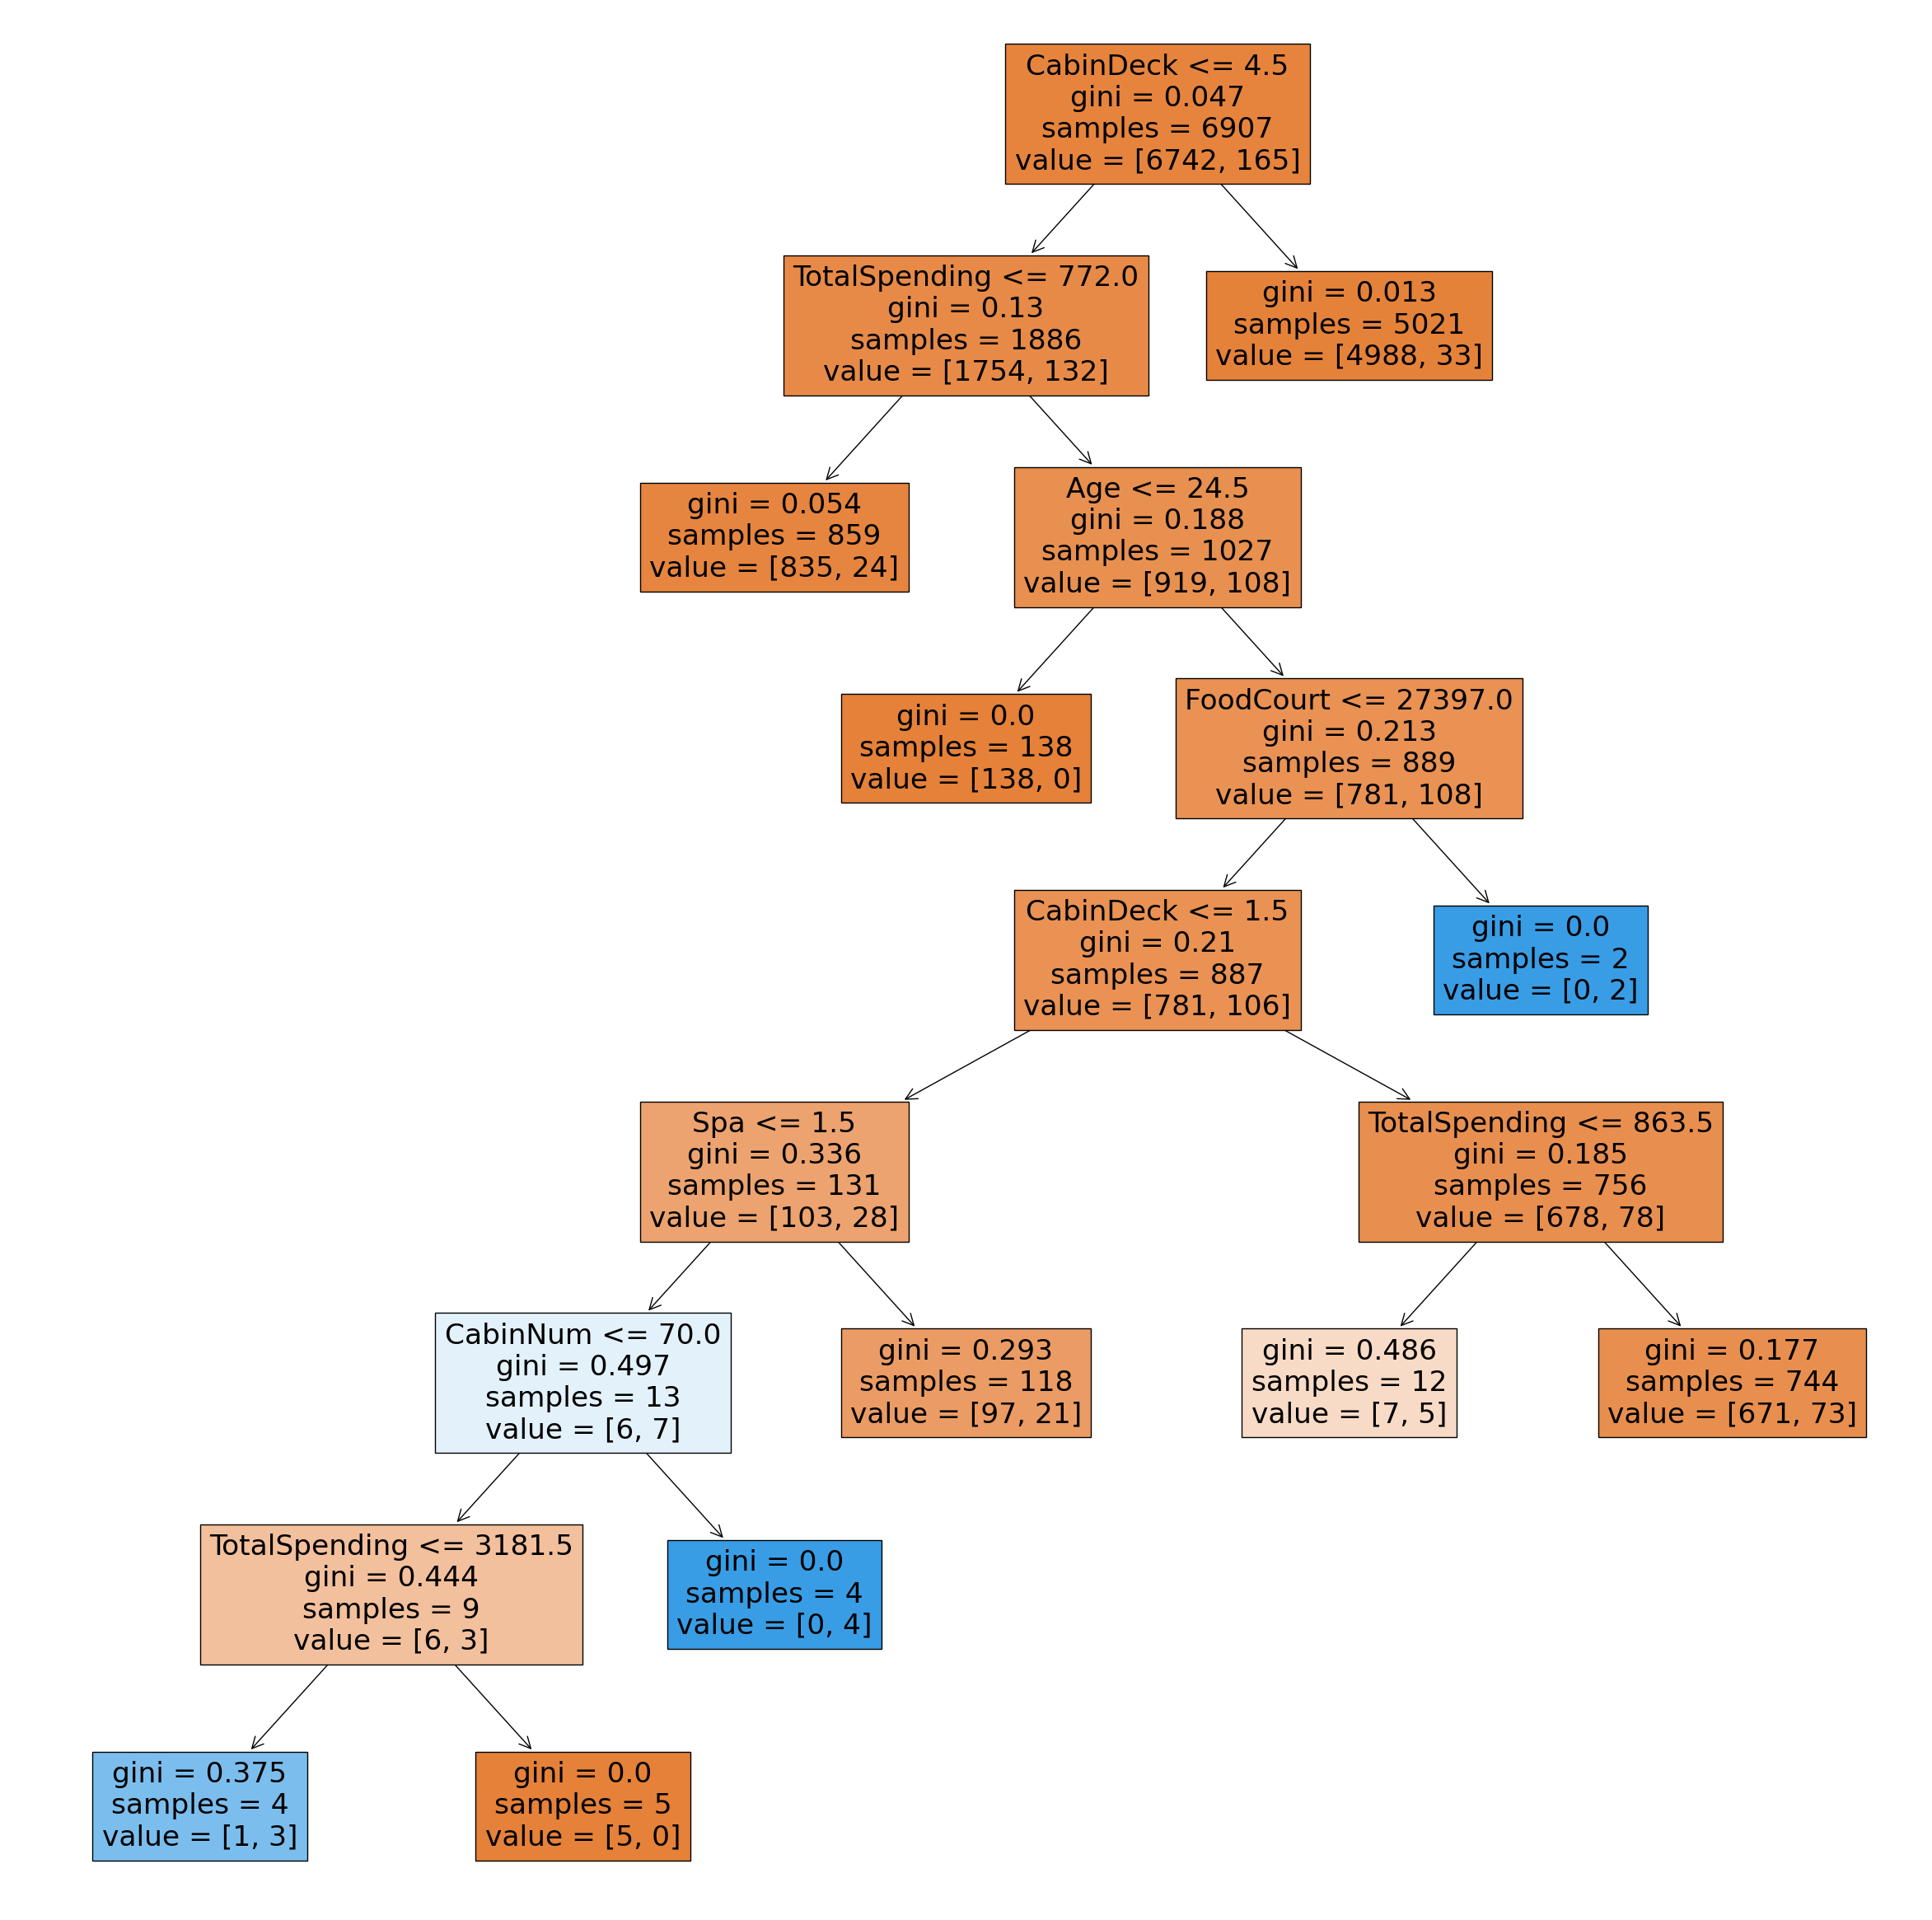

In [38]:



dep_var = 'VIP'
procs = [Categorify]

cat = ['Destination',
       'CabinDeck', 'CabinSide','CryoSleep','HomePlanet']
cont = ['Age','RoomService', 'ShoppingMall', 'Spa', 'VRDeck','CabinNum','FoodCourt','TotalSpending',
        'TotalSpendingInCabin','CabinSize']
to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var)

xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeClassifier(max_leaf_nodes=10)
m.fit(xs, y)

fig = plt.figure(figsize=(30,30))
_ = tree.plot_tree(m,
                   feature_names= xs.columns,
                   filled=True)

#print('decision tree prediction',((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y))




In [40]:


list(zip(traindf.CabinDeck.unique(),xs.CabinDeck.unique()))


[('B', 2),
 ('F', 6),
 ('A', 1),
 ('G', 7),
 ('E', 5),
 ('C', 3),
 ('D', 4),
 ('T', 8)]

In [41]:



def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi[:30])



                    cols       imp
1              CabinDeck  0.378390
12         TotalSpending  0.288115
5                    Age  0.096980
11             FoodCourt  0.085101
8                    Spa  0.083711
10              CabinNum  0.067703
0            Destination  0.000000
2              CabinSide  0.000000
3              CryoSleep  0.000000
4             HomePlanet  0.000000
6            RoomService  0.000000
7           ShoppingMall  0.000000
9                 VRDeck  0.000000
13  TotalSpendingInCabin  0.000000
14             CabinSize  0.000000


In [42]:
traindf

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FirstName,LastName,Group,GroupNumber,TotalSpending,TotalSpendingInCabin,CabinSize,CabinDeck,CabinSide,CabinNum
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Maham,Ofracculy,0001,01,0.0,0.0,1,B,P,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Juanna,Vines,0002,01,736.0,736.0,1,F,S,0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Altark,Susent,0003,01,10383.0,15559.0,2,A,S,0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Solam,Susent,0003,02,5176.0,15559.0,2,A,S,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Willy,Santantines,0004,01,1091.0,1091.0,1,F,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,Gravior,Noxnuther,9276,01,8536.0,8536.0,1,A,P,98
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,Kurta,Mondalley,9278,01,0.0,0.0,1,G,S,1499
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,Fayey,Connon,9279,01,1873.0,1873.0,1,G,S,1500
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,Celeon,Hontichre,9280,01,4637.0,9463.0,2,E,S,608


In [44]:
cd = list(traindf.CabinDeck.unique())

In [45]:
age_by_pclass_sex = traindf.groupby(['CabinDeck']).median()['Age']

for cds in cd:
    print('Median age of Pclass {} {}s: {}'.format(cds, age_by_pclass_sex[cds]))
print('Median age of all passengers: {}'.format(traindf['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
traindf['Age'] = traindf.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

TypeError: agg function failed [how->median,dtype->object]

In [ ]:

traindf.columns
raindf = traindf.drop(columns = ['PassengerId','CabinNum','Name','TotalSpending'])
raindf = pd.get_dummies(raindf)




In [ ]:


df_all_corr = raindf.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'FoodCourt']